# Load Dataset from Kaggle

In [5]:
import kagglehub

In [6]:
path = kagglehub.dataset_download("vuppalaadithyasairam/ultrasound-breast-images-for-breast-cancer")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ultrasound-breast-images-for-breast-cancer


# Check Content

In [7]:
import os

In [8]:
def list_directories(base_path):
    for root, dirs, files in os.walk(base_path):
        for d in dirs:
            full_path = os.path.join(root, d)
            relative_path = os.path.relpath(full_path, base_path)
            print(relative_path)

dataset_path = os.path.join(path, "ultrasound breast classification")

list_directories(dataset_path)

val
train
val/benign
val/malignant
train/benign
train/malignant


# Image Count per Class

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

In [10]:
image_counts = {}

for split in ['train', 'val']:
    split_path = os.path.join(dataset_path, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            count = len(os.listdir(label_path))
            image_counts[f"{split}/{label}"] = count

print(image_counts)

{'train/benign': 4074, 'train/malignant': 4042, 'val/benign': 500, 'val/malignant': 400}


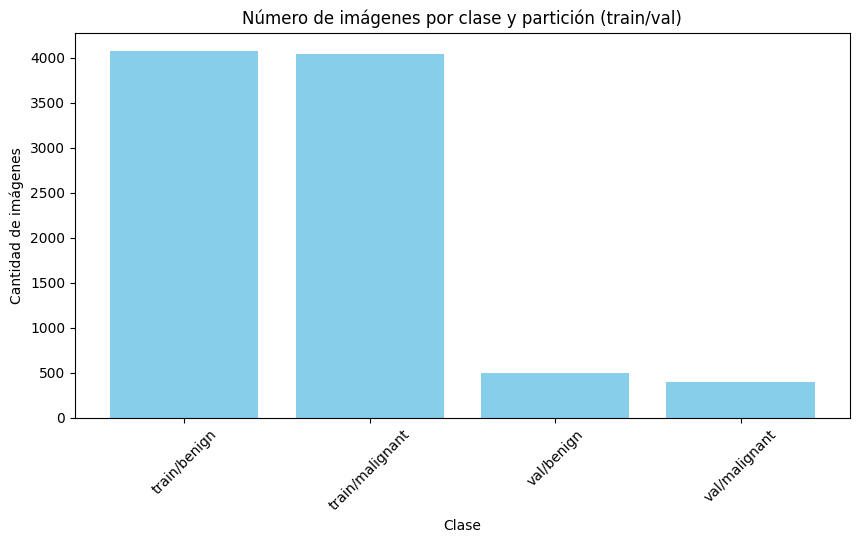

In [11]:
plt.figure(figsize=(10,5))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.title("Número de imágenes por clase y partición (train/val)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.show()

# Images

In [12]:
from PIL import Image
import numpy as np

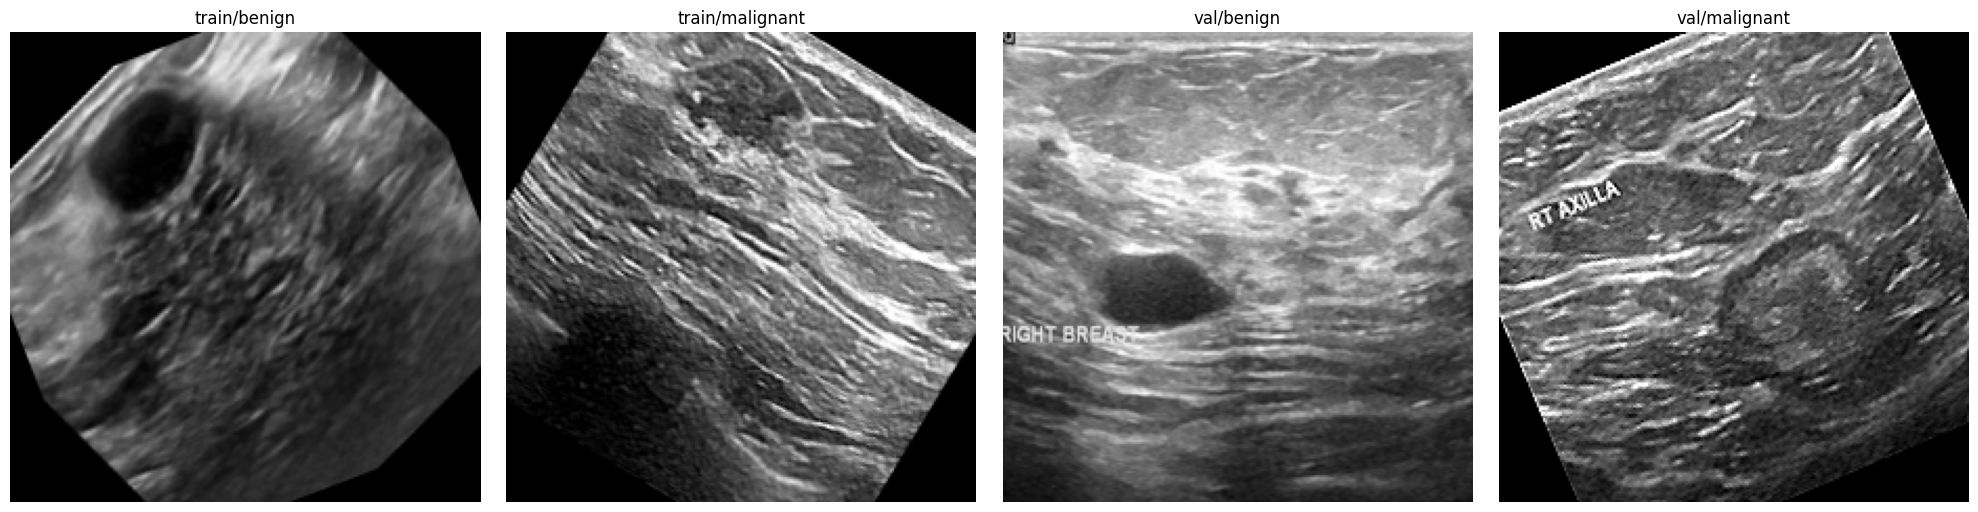

In [13]:
fig, axes = plt.subplots(1, len(image_counts), figsize=(20, 5))

for i, label in enumerate(image_counts.keys()):
    image_folder = os.path.join(dataset_path, label)
    image_files = os.listdir(image_folder)

    if len(image_files) > 0:
        image_path = os.path.join(image_folder, image_files[0])
        img = Image.open(image_path)
        axes[i].imshow(img.convert("L"), cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    else:
        axes[i].set_title(f"{label}\n(sin imágenes)")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Average Dimensions

In [14]:
dims = []

for label in image_counts.keys():
    folder = os.path.join(dataset_path, label)
    for img_name in os.listdir(folder)[:50]:
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        dims.append(img.size)

dims = np.array(dims)
print(f"Dimensiones promedio (width, height): {np.mean(dims, axis=0)}")

Dimensiones promedio (width, height): [224.105 224.105]


# Data Segmentation

In [15]:
!pip install tensorflow

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [17]:
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 8116 files belonging to 2 classes.
Found 900 files belonging to 2 classes.


# Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds_augmented = train_ds_augmented.prefetch(buffer_size=AUTOTUNE)

# Models

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

In [20]:
VGG16_base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
VGG16_base_model.trainable = False

VGG16_model = models.Sequential([
    VGG16_base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

VGG16_model_aug = models.Sequential([
    VGG16_base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [21]:
VGG16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

VGG16_model_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [22]:
VGG16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 82s 248ms/step - accuracy: 0.7666 - loss: 0.8576 - val_accuracy: 0.8400 - val_loss: 0.3373
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 45s 176ms/step - accuracy: 0.9107 - loss: 0.2138 - val_accuracy: 0.8278 - val_loss: 0.3296
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 46s 180ms/step - accuracy: 0.9311 - loss: 0.1681 - val_accuracy: 0.8467 - val_loss: 0.3119
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - accuracy: 0.9295 - loss: 0.1581 - val_accuracy: 0.8389 - val_loss: 0.4921
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 45s 176ms/step - accuracy: 0.9491 - loss: 0.1169 - val_accuracy: 0.8611 - val_loss: 0.3302
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step - accuracy: 0.9353 - loss: 0.1358 - val_accuracy: 0.8389 - val_loss: 0.4853
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 45s 177ms/step - accuracy: 0.9264 - loss: 0.1464 - val_accuracy: 0.8578 - val_loss: 0.4742
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 45s 177ms/step - accuracy: 0.9393 - loss: 0

In [23]:
VGG16_model_aug.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 129s 486ms/step - accuracy: 0.7172 - loss: 0.8747 - val_accuracy: 0.8111 - val_loss: 0.3931
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 120s 470ms/step - accuracy: 0.8235 - loss: 0.3984 - val_accuracy: 0.8156 - val_loss: 0.3419
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 117s 459ms/step - accuracy: 0.8225 - loss: 0.3896 - val_accuracy: 0.8444 - val_loss: 0.3558
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 144s 468ms/step - accuracy: 0.8311 - loss: 0.3739 - val_accuracy: 0.8333 - val_loss: 0.3159
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 141s 465ms/step - accuracy: 0.8477 - loss: 0.3352 - val_accuracy: 0.8600 - val_loss: 0.2726
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 120s 472ms/step - accuracy: 0.8564 - loss: 0.3238 - val_accuracy: 0.8633 - val_loss: 0.3075
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 118s 463ms/step - accuracy: 0.8483 - loss: 0.3363 - val_accuracy: 0.8389 - val_loss: 0.3220
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 120s 472ms/step - accuracy: 0.8570 -

# Models Evaluation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step


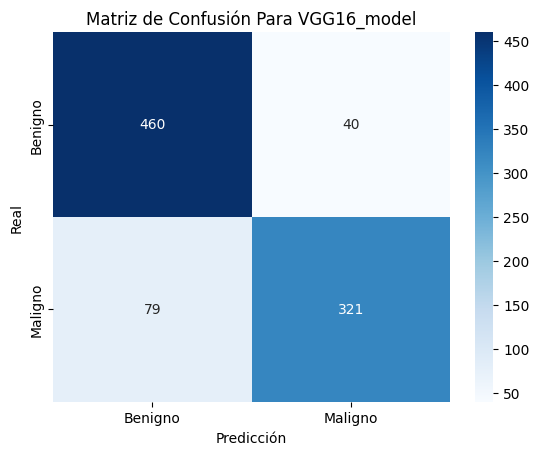

              precision    recall  f1-score   support

     Benigno       0.85      0.92      0.89       500
     Maligno       0.89      0.80      0.84       400

    accuracy                           0.87       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.87      0.87      0.87       900



In [25]:
y_pred_probs = VGG16_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para VGG16_model')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))

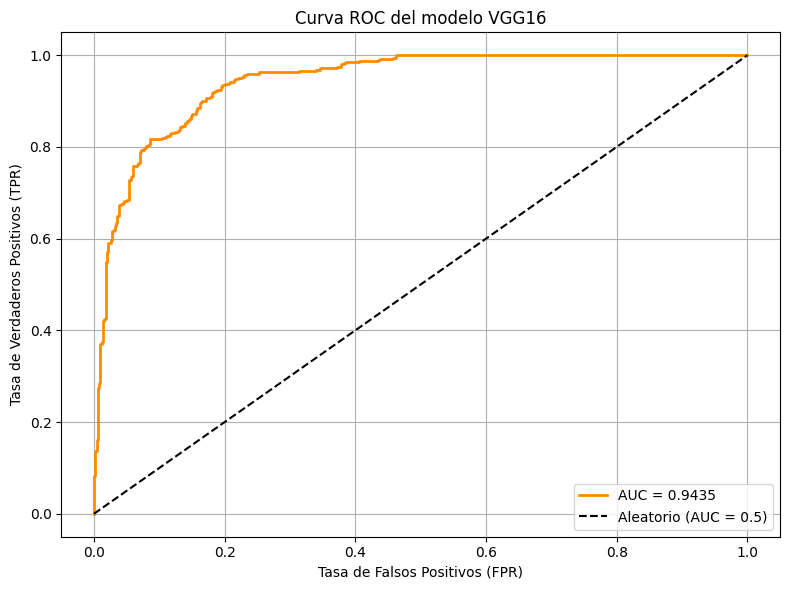

In [26]:
y_scores = y_pred_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del modelo VGG16')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step


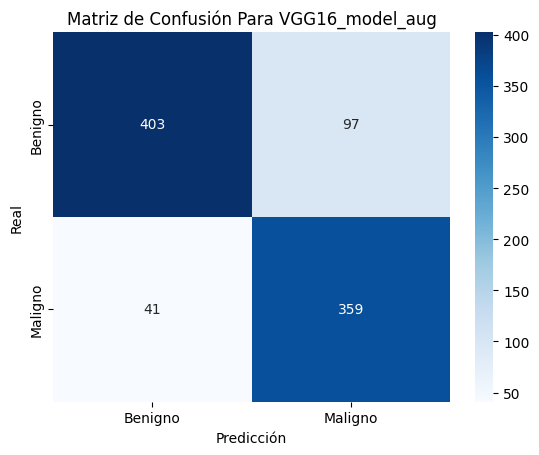

              precision    recall  f1-score   support

     Benigno       0.91      0.81      0.85       500
     Maligno       0.79      0.90      0.84       400

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900



In [27]:
y_pred_probs_aug = VGG16_model_aug.predict(val_ds)
y_pred_aug = np.argmax(y_pred_probs_aug, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred_aug)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para VGG16_model_aug')
plt.show()

print(classification_report(y_true, y_pred_aug, target_names=['Benigno', 'Maligno']))

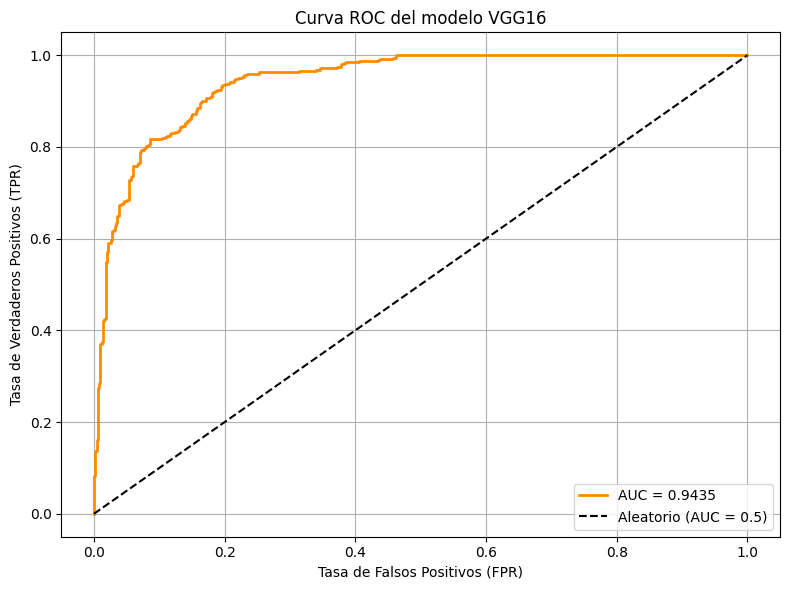

In [28]:
y_scores = y_pred_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del modelo VGG16')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Fine-tuning

In [29]:
VGG16_base_model.trainable = True
for layer in VGG16_base_model.layers[:-4]:
    layer.trainable = False

In [30]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

VGG16_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 70s 252ms/step - accuracy: 0.9531 - loss: 0.0811 - val_accuracy: 0.8844 - val_loss: 0.5453
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 68s 216ms/step - accuracy: 0.9589 - loss: 0.0651 - val_accuracy: 0.8944 - val_loss: 0.5532
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.9604 - loss: 0.0597 - val_accuracy: 0.8967 - val_loss: 0.6830
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9694 - loss: 0.0511 - val_accuracy: 0.9033 - val_loss: 0.6312
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step - accuracy: 0.9789 - loss: 0.0383 - val_accuracy: 0.8944 - val_loss: 0.6193


In [31]:
VGG16_model_aug.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

VGG16_model_aug.fit(train_ds_augmented, validation_data=val_ds, epochs=5)

Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 135s 508ms/step - accuracy: 0.9045 - loss: 0.2278 - val_accuracy: 0.9433 - val_loss: 0.1435
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 123s 483ms/step - accuracy: 0.9320 - loss: 0.1610 - val_accuracy: 0.9289 - val_loss: 0.1776
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 140s 474ms/step - accuracy: 0.9492 - loss: 0.1154 - val_accuracy: 0.9444 - val_loss: 0.1707
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 122s 477ms/step - accuracy: 0.9619 - loss: 0.0920 - val_accuracy: 0.9400 - val_loss: 0.1747
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 121s 474ms/step - accuracy: 0.9678 - loss: 0.0764 - val_accuracy: 0.9544 - val_loss: 0.1509


# Fine-tuning Evaluation

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step


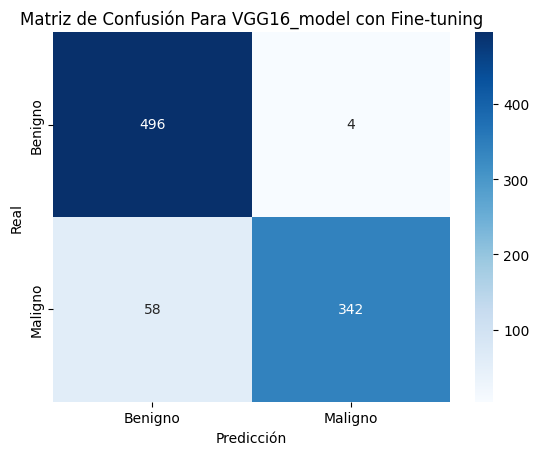

              precision    recall  f1-score   support

     Benigno       0.90      0.99      0.94       500
     Maligno       0.99      0.85      0.92       400

    accuracy                           0.93       900
   macro avg       0.94      0.92      0.93       900
weighted avg       0.94      0.93      0.93       900



In [32]:
y_pred_probs = VGG16_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para VGG16_model con Fine-tuning')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))

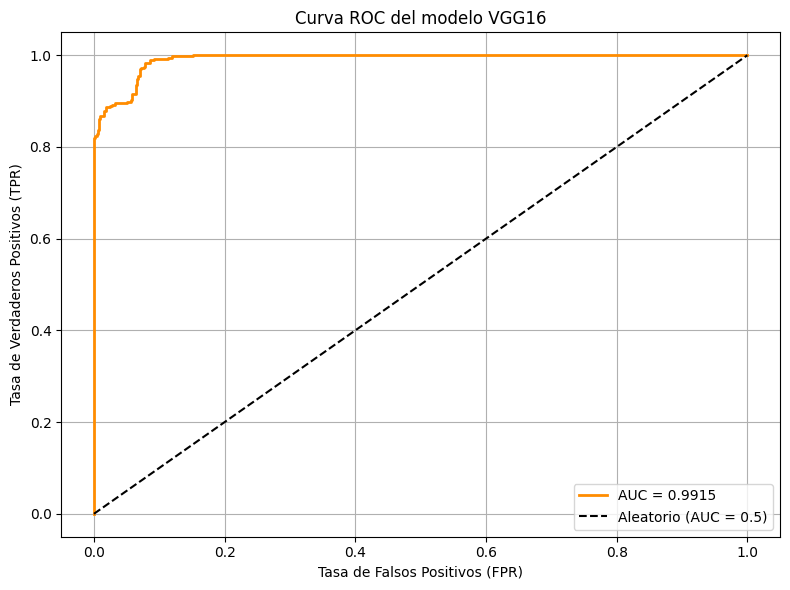

In [33]:
y_scores = y_pred_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del modelo VGG16')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step


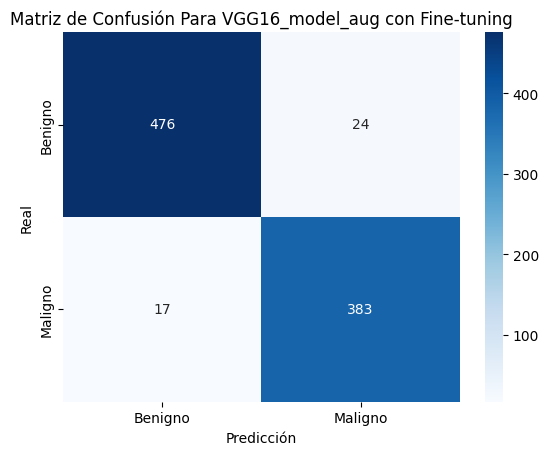

              precision    recall  f1-score   support

     Benigno       0.97      0.95      0.96       500
     Maligno       0.94      0.96      0.95       400

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [34]:
y_pred_probs_aug = VGG16_model_aug.predict(val_ds)
y_pred_aug = np.argmax(y_pred_probs_aug, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred_aug)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Para VGG16_model_aug con Fine-tuning')
plt.show()

print(classification_report(y_true, y_pred_aug, target_names=['Benigno', 'Maligno']))

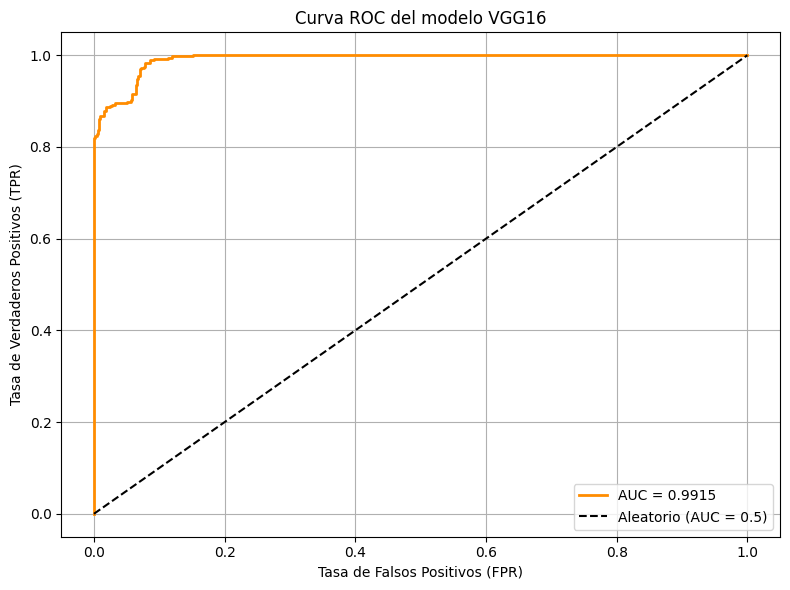

In [35]:
y_scores = y_pred_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del modelo VGG16')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Model

In [36]:
VGG16_model.save('modelo_cancer_mama_vgg16.keras')
VGG16_model_aug.save('modelo_aug_cancer_mama_vgg16.keras')